# A Brief Introduction to Bayesian Data Analysis

<i>Alfred J. Reich</i>

## Overview

This notebook uses a very simple simulation (inefficient, but lucid) to illustrate how the <b>Bayesian posterior</b> distribution for a <b>Binomial</b> <i>success rate</i> (i.e., a <i>parameter</i>) can be computed when a <b>Uniform prior distribution</b> on the parameter is assumed.

Following that demonstration, the 90+ continuous distributions of <i>SciPy.stats</i> are searched to find the distribution that best fits the posterior distribution found, above.  (<u>Spoiler Alert</u>: The best fitting distribution closely matches the well-known theoretical answer to this problem, the <b>Beta distribution</b>.)

Finally, we will do the whole thing all over again, succinctly and quickly (i.e., efficient, but less lucid), using a <b>Markov chain Monte Carlo (MCMC)</b> simulation.

## Dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [2]:
import numpy as np
import scipy.stats as ss
from scipy.stats import binom, uniform
from functools import reduce
import fitdist as fd  # https://github.com/alreich/fitdist
import warnings
warnings.simplefilter('ignore')

# NOTE: arviz needs to be installed in the Python environment, but not imported directly

## Probability & Statistics

<b><i>Probability Theory</i></b> is concerned with mathematical models of random phenomena.


Some important concepts in probability theory are:  (quantities here can be scalars or vectors)

* The <b><i>Random Variable (RV)</i></b> and its associated <b><i>Distribution Function (DF)</i></b>
  * usually written $X \sim F(x;\theta)$
  * where $x$ represents a value of the RV
  * and $\theta$ is a parameter that affects the shape of the DF
* The <b><i>Expectated Value</i></b> of a RV
  * Defined as $E(X) = \int_{\Omega} \! x \, \mathrm{d}F$
  * where $\Omega$ is the sample space of all possible outcomes of $X$
* The <b><i>Independence</i></b> of two random variables $X$ and $Y$
  * sometimes written $X \perp Y$
  * the outcome of $X$ has no effect on the outcome of $Y$, and vice versa
  * $X \perp Y$ iff $F_{X,Y}(x,y) = F_X(x)F_Y(y)$
    * where $F_{X,Y}, F_X, F_Y$ are the joint and individual distributions of $X$ & $Y$, resp.

<i><b>Mathematical Statistics</b></i> is a subfield of Probability Theory concerned with derivation of features of a probability model based on a set of RVs from the model.  Often the set of RVs are assumed to be <i><b>Independence and Identically Distributed (i.i.d.)</b></i>.

If $X_1,X_2,...,X_n$ are independent and identically (iid) distributed RVs with distribution $F(x;\theta)$, and $g(x_1,x_2,...,x_n)$ is a function such that $E(g(X_1,X_2,...X_n)) = \theta$, then $g$ is called a <b><i>statistic</i></b>, and it is also an <i><b>unbiased estimator</b></i> of $\theta$.

## Statistical Modeling Assumptions

The probabilistic assumptions that go into statistical inferences can be categorized into three levels, where at each level, the assumptions that are made increase.

(Note: Random variables and parameters described below can be scalars or vectors.)

### 1. Exploratory

No modeling assumptions

#### Examples

* Average
* Median
* Quantiles
* Quantile Ranges
* Minimum/Maximum
* Histogram

### 2. Frequentist / Classical

Assumes a random variable, $X$, with a specific probability distribution, $F$ and fixed parameters, $\theta$:

$X \sim F(x;\theta)$

#### Example

Let $\Phi$ be the standard normal distribution and $\theta = \begin{pmatrix} \mu \\ \sigma \end{pmatrix}$, where $- \infty < \mu < + \infty$ and $\sigma > 0$,

then $F(x;\theta) \equiv \Phi({{x - \mu} \over \sigma})$ is one of the most commonly used models in all of statistics.

### 3. Bayesian

Assumes a random variable, $X$, with a specific probability distribution, $F$, and <b>random</b> parameter, $\Theta$, with its own distribution, $G$, and fixed parameter, $\gamma$, sometimes called a hyper-parameter:

$X \sim F(x;\Theta)$ where $\Theta \sim G(\theta;\gamma)$

Here $F$ is referred to as the <b><i>likelihood</i></b> and $G$ as the <b><i>prior</i></b> distribution.

#### Example

We'll use $K$ for the name of the random variable here, instead of $X$.

$K \sim Binomial(n,k,\Theta) \equiv \binom{n}{k} \Theta^k(1-\Theta)^{n-k}$
> <p>where</p>
> <p>$n \in \{1,2,3,...\}$ -- Number of trials (a fixed value)</p>
> <p>$k \in \{0,1,2,...,n\}$ -- Number of successes</p>
> <p>$\theta \in [0,1]$ -- Success probability for each trial</p>

$\Theta \sim Beta(\alpha, \beta) \equiv \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \theta^{\alpha - 1} (1-\theta)^{\beta - 1}$
> <p>where $\alpha > 0$ and $\beta > 0$</p>

## Bayesian Data Analysis

(briefly describe the Bayesian approach)

## Binomial Distribution

The binomial probability distribution is a discrete distribution representing the probability of <b>k</b> successes in <b>n</b> independent trials, where the probability of success on each individual trial is <b>p</b>.

The most common problem we run into in the <i>real world</i> is where we've observed k successes n attempts ($k = 0,...,n$) and we want an estimate of the probability of a success, $p$.  An obvious guess for $p$ is $k/n$, and it turns out that, that if we use the binomial probability distribution, $k/n$ is the <i>Maximum Likelihood Estimator (MLE)</i> for $p$.

### Example 1

<u>Question</u>:

* Toss a fair coin 4 times.
* What is the probability that we will see exactly 2 heads (H) in the 4 tosses?

<u>Answer</u>:

* There are $2^4 = 16$ ways, in sequential order, that the 4 tosses can occur (HHHH, HHHT, HHTH, ..., TTTT).
* Each is equally likely, so each has probability 1/16 of occurring.
* Only 6 of the ways contain exactly 2 heads: HHTT, HTHT, HTTH, THHT, THTH, TTHH.
* So the probability of getting 2 heads in 4 coin tosses is $6*(1/16) = 0.375$.

Or, we can use SciPy's binomial <b>probability mass function (PMF)</b> as follows:

In [4]:
binom.pmf(2, 4, 1/2)  # 2 successes in 4 trials with p = 1/2

0.3750000000000001

### General Form of the Binomial PMF

In general, the form of the binomial PMF is the following.

$f(k;p,n) =  \binom{n}{k} p^k(1-p)^{n-k}$, for $k \in \{0,1,2,...,n\}$ and where $\binom{n}{k} = \frac{n!}{k!(n-k)!}$

The $\binom{n}{k}$ in the formula above provides the number of ways <b>k</b> successes can occur in <b>n</b> trials. So, for the example here: $\binom{4}{2} = \frac{4!}{2!(4-2)!} = 6$.

Just FYI, the theoretical <b>mean</b> and <b>variance</b> of a <b>binom(n,k)</b> are as follows:

$E(X) = np$
<p>$Var(X) = np(1−p)$</p>

### Example 2

Consider the probability of <b>k</b> successes in 20 independent trials, where the probability of success on each individual trial is <b>30%</b>.

That is,

* n = 20
* p = 0.3
* Possible values of k are 0, 1, 2, ... , 20

In [5]:
n = 20
p = 0.3

In [6]:
print(f"So, theoretically, we should see np = {n} x {p} = {n*p} successes.")

So, theoretically, we should see np = 20 x 0.3 = 6.0 successes.


In [7]:
print(f"Or, using SciPy.stat's binomial random variable: {binom(n,p).mean()} successes")

Or, using SciPy.stat's binomial random variable: 6.0 successes


Of course, other outcomes are possible.  We can get anywhere from 0 to 20 successes in 20 trials.  The probabilities for each of the 21 possible outcomes (values of k) are shown in the graph below.  The <b>Binomial(20, 0.3)</b> PMF is graphed below.

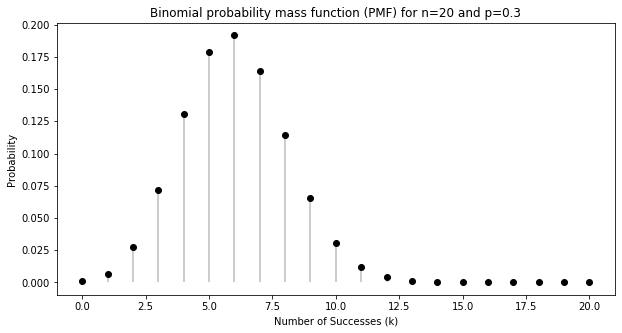

In [8]:
x = np.arange(0, n + 1)

figsize(10,5)
plt.plot(x, binom.pmf(x,n,p), 'ko')
plt.vlines(x, 0, binom.pmf(x,n,p), colors='k', lw=2, alpha=0.2)
plt.title('Binomial probability mass function (PMF) for n={} and p={}'.format(n, p))
plt.xlabel('Number of Successes (k)')
plt.ylabel('Probability')
plt.show()

## Maximum Likelihood Method

We can also use the <b>binom</b> function in <i>scipy.stats</i> to generate <b>simulated values</b> for <b>k</b>, the number of successes in <b>n</b> trials where the probability of a success is <b>p</b>.

Each call to <b>binom.rvs(n,p)</b> generates a count of successes as if n trials occurred with probability p of success.

In [15]:
print(f"{n} independent trials where p={p} results in {binom.rvs(n,p)} successes")

20 independent trials where p=0.3 results in 8 successes


For example, below, we'll call the same function over and over, <b>m</b> times, and then graph a histogram of the results.  It should have a similar shape to the PMF above, except that it's not scaled to be a density function.

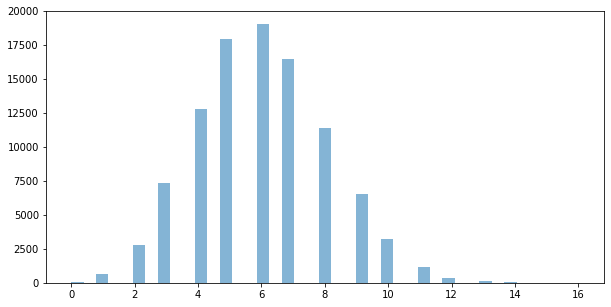

In [20]:
m = 100_000  # Number of simulated values
binom_sample = list(map(lambda x: binom.rvs(n,p), range(m)))
_ = plt.hist(binom_sample, bins=2*n+1, alpha=0.55)

If we conduct $i=1,...,m$ trials,
<p>where $k_i$ is the number of successes on the $i^{th}$ trial,</p>
<p>then the Maximum Likelihood Estimator (MLE) of $p$ for each individual trial is $\hat{p}_i = {k_i \over n}$</p>
<p>and the MLE for $p$ using the entire set of trials is</p>
<p><center>$\hat{p} = {1 \over m}\left( \sum_{i=1}^{m} \hat{p}_i \right) = {1 \over m}\left( \sum_{i=1}^{m} {k_i \over n} \right)$,</center></p>

In [21]:
sum = reduce((lambda x, y: x + y), binom_sample)
print(f"Using the data just generated, the MLE for p is {sum/(m*n)}")

Using the data just generated, the MLE for p is 0.3000905


## Bayesian Method

Suppose we've run a real-world experiment consisting of a series of $n$ independent trials, where each trial has an unknown probability, $p$, of success, and we've observed a total of $k$ successes.

Then initialize an empty list called <i>posteriors</i>, and do the following:

1. Since we don't know $p$, randomly choose a value, $p_i$, from the Uniform(0,1) distribution
1. Using $p_i$, compute a random value, $k_i$, from a Binomial($n$,$p_i$) distribution
1. If $k_i = k$ save $k_i$ in <i>posteriors</i>, otherwise discard $k_i$.

In [22]:
m = 1_000_000  # Number of priors to use
hbins = 25  # Number of bins for histograms
n = 20  # Number of trials in our real-world experiment
k = 6  # Number of observed successes in our real-world experiment

The way we'll code this is very simple and succinct for pedigogical purposes.

Let's first compute a list of priors, as described in Step 1, above:

First three priors: [0.5681425100647833, 0.26336624990784896, 0.8574851010660728]


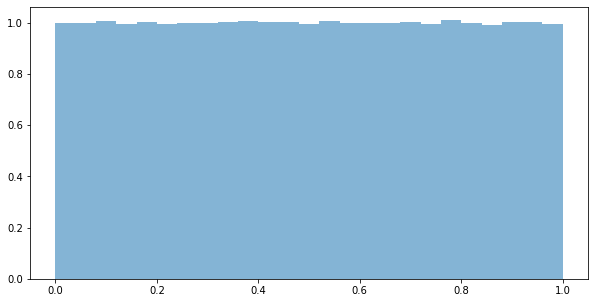

In [23]:
priors = list(uniform.rvs(size=m))

print(f"First three priors: {priors[:3]}")

_ = plt.hist(priors, bins=hbins, density=True, alpha=0.55)

### Here's the key thing we want to do...

Go through the priors, using each one (p) to simulate Binomial(n,p) observations, keeping only those that match the observed number of successes.

The result, will be the distribution of priors that yielded matches to our actual data (i.e., k = 6).

CPU times: user 34.2 s, sys: 537 ms, total: 34.7 s
Wall time: 34.3 s
Number of matches = 47564


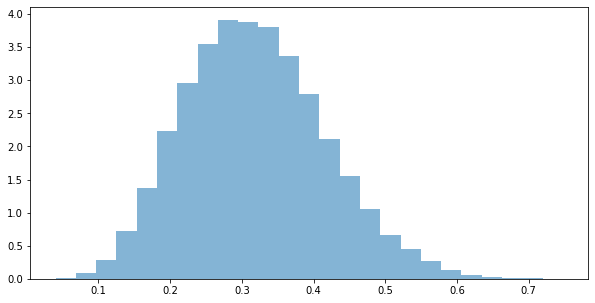

In [24]:
%time posteriors = [p for p in priors if binom.rvs(n,p)==6]

print("Number of matches = {}".format(len(posteriors)))
_ = plt.hist(posteriors, bins=hbins, density=True, alpha=0.55)

## Best Fitting Distribution

In [25]:
fit_results = fd.find_best_fit_distributions(posteriors,
                                             dist_names = fd.common_cont_dist_names,
                                             goodness_of_fit_pvalue = 0.25,
                                             drop_dist_names = []
                                            )

/Users/alfredreich/anaconda3/envs/bayes/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1682: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/Users/alfredreich/anaconda3/envs/bayes/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:6470: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)
/Users/alfredreich/anaconda3/envs/bayes/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [26]:
fit_results

[['beta',
  (7.101931564964702,
   15.949316825245182,
   -0.00037698998075126107,
   1.035430883185067),
  0.6487363773139669]]

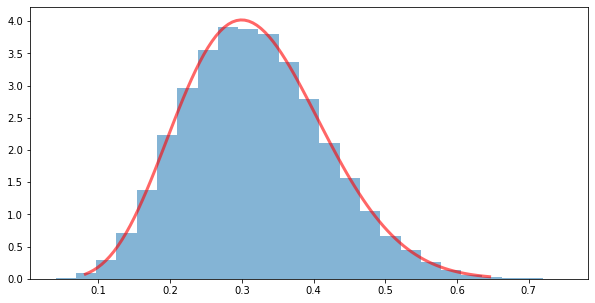

In [38]:
from scipy.stats import beta

pos = 0
mle = fit_results[pos][1]
dist_name = "beta"

x = np.linspace(beta.ppf(0.001, *mle), beta.ppf(0.999, *mle), 100)

plt.plot(x, beta.pdf(x, *mle), 'r-', lw=3, alpha=0.6, label=dist_name)

_, _, _ = plt.hist(posteriors, hbins, density=True, alpha=0.55)

In [44]:
print(f"The red line is approximately a {dist_name}({int(round(mle[0]))},{int(round(mle[1]))}) distribution")

The red line is approximately a beta(7,16) distribution


### The result matches the theory very well...

The <b>Uniform(0,1)</b> prior, used above, is equivalent to a <b>Beta(1,1)</b> prior.  And, since the beta prior is conjugate with binomial likelihoods, the posterior should be a <b>Beta( 6 + 1, 20 - 6 + 1 ) = Beta(7,15)</b> which is close to what we obtained above.

Here's the math:

First of all, the Uniform distribution is equivalent to a Beta distribution:
<p><center>$U(0,1) \equiv Beta(1,1)$</center></p>
<p>Then, assuming the <i>prior</i> and the <i>likelihood</i> are as follows:</p>
<p><center><u>Prior</u>:  $\pi(\theta) \sim Beta(\alpha, \beta) \equiv \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \theta^{\alpha - 1} (1-\theta)^{\beta - 1}$</center></p>
<p><center><u>Likelihood</u>:  $Y \sim Binomial(n,k,\theta) \equiv \binom{n}{k} \theta^k(1-\theta)^{n-k}$</center></p>
<p>So, multiplying the two, followed by some algebraic manipulation, we arrive at:</p>
<p><center><u>Posterior</u>:  $\pi(\theta \mid Y=k) \sim Beta(k+\alpha, n-k+\beta)$</center></p>

## Bibliography

1. <u>Introduction to Mathematical Statistics</u> ...
1. A discussion about the ambiguity of commonly used probability notations: [What’s Wrong with Probability Notation?](https://lingpipe-blog.com/2009/10/13/whats-wrong-with-probability-notation/)